# Lab 8-2: Modeling a snowpack with a gridded, numerical model - openAMUNDSEN

From the documents:

> openAMUNDSEN is a fully distributed model, designed primarily for resolving the mass and energy balance of snow and ice covered surfaces in mountain regions. Typically, it is applied in areas ranging from the point scale to the regional scale (i.e., up to some hundreds to thousands of square kilometers), using a spatial resolution of 10–100 m and a temporal resolution of 1–3 h, however its potential applications are very versatile.

You can learn more about the model here http://doc.openamundsen.org.

We run the model the entire upper East River Basin. We provide as inputs precipitation and meteorological (air temp, $SW_{in}$, etc) conditions measured at Kettle Ponds as well a 50-meter resolution digital elevation model (DEM) of the upper East River Basin.

In [1]:
# pip install openamundsen

In [2]:
import openamundsen as oa

import xarray as xr
import rioxarray as rix


import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

from metpy.units import units
from metpy import constants

import altair as alt
import matplotlib.pyplot as plt

# Run Model

The model requires the following files to run:
* a csv file of inputs (`1.csv`), 
* a csv of the locations of the input measurements (`stations.csv`), 
* a DEM of the model domain (`dem_uppereastriver_50.asc`, also files with the same name ending with extensions `.prj` and `.asc.aux.xml`)
* a gridded mask indicating where to run the model (`roi_uppereastriver_50.asc|.prj`)
All of these files are within a compressed directory, which you can download form the Module 8 web page.

To get the model ready to run, download the compressed directory of model inputs by clicking the link `openAMUNDSEN Inputs` on the Module 8 webpage. 
Once downloaded, unzip this directory and place it in a directory `../data/` such that there exists a directory `../data/openamundsen/`.
Then, download the `openAMUNDSEN Configuration File`` (also linked on the Module 8 web page), and place it in the same directory as this notebook file.

Once you follow the steps above, the following command should show you a bunch of model input files:

In [3]:
ls ../data/openamundsen

1.csv                              roi_uppereastriver_50.asc
dem_uppereastriver_50.asc          roi_uppereastriver_50.prj
dem_uppereastriver_50.asc.aux.xml  stations.csv
dem_uppereastriver_50.prj


Here is how we run the model.

1. read the config and set up a model object.

In [4]:
config = oa.read_config('open_amundsen_config.yml')  # read in configuration file
model = oa.OpenAmundsen(config)  # create OpenAmundsen object and populate unspecified parameters with default values

2. Initialize the model.

If there are any problems with your inputs, errors will be thrown here.

In [5]:
model.initialize()  # read in input data files, initialize state variables etc.

2025-02-27 12:18:29 | INFO     | Initializing model grid
2025-02-27 12:18:29 | INFO     | Grid has dimensions 337x280
2025-02-27 12:18:29 | INFO     | Reading DEM (../data/openamundsen/dem_uppereastriver_50.asc)
2025-02-27 12:18:29 | INFO     | Calculating sky view factor
2025-02-27 12:18:29 | INFO     | Calculating sky view factor for azimuth=0° (1/36)
2025-02-27 12:18:32 | INFO     | Calculating sky view factor for azimuth=10° (2/36)
2025-02-27 12:18:32 | INFO     | Calculating sky view factor for azimuth=20° (3/36)
2025-02-27 12:18:32 | INFO     | Calculating sky view factor for azimuth=30° (4/36)
2025-02-27 12:18:32 | INFO     | Calculating sky view factor for azimuth=40° (5/36)
2025-02-27 12:18:32 | INFO     | Calculating sky view factor for azimuth=50° (6/36)
2025-02-27 12:18:32 | INFO     | Calculating sky view factor for azimuth=60° (7/36)
2025-02-27 12:18:33 | INFO     | Calculating sky view factor for azimuth=70° (8/36)
2025-02-27 12:18:33 | INFO     | Calculating sky view fa

3. Run the model. This will take about two minutes with our current configuration.

In [6]:
model.run()  # run the model

2025-02-27 12:18:36 | INFO     | Starting model run
2025-02-27 12:18:36 | INFO     | Processing time step 2022-11-16 00:00
2025-02-27 12:18:42 | INFO     | Processing time step 2022-11-16 03:00
2025-02-27 12:18:42 | INFO     | Processing time step 2022-11-16 06:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-16 09:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-16 12:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-16 15:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-16 18:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-16 21:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-17 00:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-17 03:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-17 06:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-17 09:00
2025-02-27 12:18:43 | INFO     | Processing time step 2022-11-17 12:00
2025-02-27 12:18:43 | INF

# Examine results

Now, let's open up the model results and check them out! There are two types of model result output files. 


**Point data** results are results *at Kettle Ponds*. We configured the model (in the yml file) to save results at the Kettle Ponds location. You can add additional points at which to save model results. Point results have the full suite of model outputs, for each 3-hour timestep. By default, all outputs are saved for point data results. 

**Gridded data** results are results for the entire watershed, i.e. modeled values at each grid cell, where grid cells are 4. By default, limited gridded model results are saved to file because the size of the outputs are large. We configured the model (in the yml file) to only save the snow melt variable. If you are interested in checking out other gridded results, look in the configuration file, under the section `grids: variables:`, and add variables there, and then rerun the model. 

We will look at model results and compare them to measurements from the Kettle Ponds site. So let's open up the measured SOS data.

In [7]:
measured = xr.open_dataset('../data/sos_full_dataset_30min.nc')

## Point Results

In [8]:
# We grab the point `kps` right off the bat b/c it's the only point with data inside this dataset.
modeled = xr.open_dataset("openamundsen_results/output_timeseries.nc").sel(point='kps')

Resample the 30-minute measurements to match the 3-hour model results. Resampling using a pandas dataframe is way faster than using an xarray dataset, so we convert to dataframe, perform the resampling, then convert back to an xarray dataset. We also trim the measurements to match the time period of the model.

In [9]:
measured = measured.to_dataframe().resample('3h').mean().to_xarray()
measured = measured.sel(time = slice(modeled.time.min(), modeled.time.max()))

### Compare measured and modeled SWE

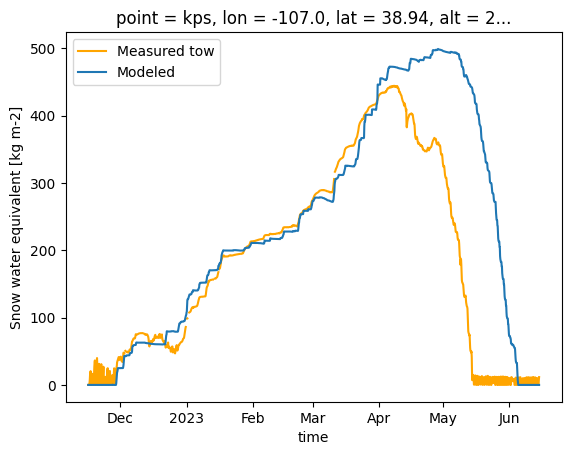

In [10]:
measured['SWE_p3_c'].sel(time=slice('20221110', '20230630')).plot(label='Measured tow', color='orange')
modeled.swe.sel(time=slice('20221110', '20230630')).plot(label='Modeled')
plt.legend()
plt.show()

We see that modeled SWE divergences from meausred SWE at the beginning of April. 
Let's examine the measured and modeled energy balances during the first half of April.

#### Calculate energy balance terms

We will focus on the following energy balance terms: $R_{net}$, $H_L$, $H_s$, and $P$, where $P$ is the precipitation energy flux. We found in previous labs that the ground heat flux $G$ and internal energy $dU/dt$ terms are generally small, so we omit them here for simplicity.
$P$ is generally small because the snowfall is usually pretty close in temperature to the snowpack, but for the homework assignment, we will model a rain-on-snow event, where $P$ can be large (i.e. rain is warmer than the snowpack, so rainfall results in warming of the snowpack).

#### Modeled

In [11]:
# Net Radiation
modeled['Rnet'] = modeled['sw_in'] - modeled['sw_out'] + modeled['lw_in'] - modeled['lw_out']

# Precipitation energy flux
temp_difference = (
    modeled.temp - modeled.surface_temp
) * units("kelvin")
precip_per_3hours = modeled.precip * units("kg/m^2")
seconds_in_3hours = 10800 * units('seconds')
precip_rate = precip_per_3hours / seconds_in_3hours
modeled['P'] = (precip_rate * constants.water_specific_heat * temp_difference)

# Note that HL and Hs, in the modeled modeled, are already in units of W/m^2
print(modeled['sens_heat_flux'].attrs['units'])
print(modeled['lat_heat_flux'].attrs['units'])

W m-2
W m-2


#### Measured

In [12]:
measured['Rnet'] = measured['Rsw_in_9m_d'] - measured['Rsw_out_9m_d'] + measured['Rlw_in_9m_d'] - measured['Rlw_out_9m_d']

# Precipitation energy flux, use modeled precip b/c that's an input, and we don't have the precip dataset loaded, so this is convenient
temp_difference = (
    measured['T_3m_c'] - measured['Tsurf_c']
) * units("kelvin")
precip_per_3hours = modeled.precip * units("kg/m^2")
seconds_in_3hours = 10800 * units('seconds')
precip_rate = precip_per_3hours / seconds_in_3hours
measured['P'] = (precip_rate * constants.water_specific_heat * temp_difference)

# convert measured sensible and latent heat fluxes to W/m^2. See Lab5-1.
# Note that while the modeled sensible and latent heat fluxes are **into** the snowpack,
#   our measurements of heat flux are **upwards/away** from the snowpack. So we negate 
#   the measured values to match the modeled values.
latent_heat_sublimation = 2590 #J/g
measured['lat_heat_flux'] = - 1 * measured['w_h2o__3m_c'] * latent_heat_sublimation

specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
measured['sens_heat_flux'] = - 1 * measured['w_tc__3m_c'] * specific_heat_capacity_air * air_density

#### Compare

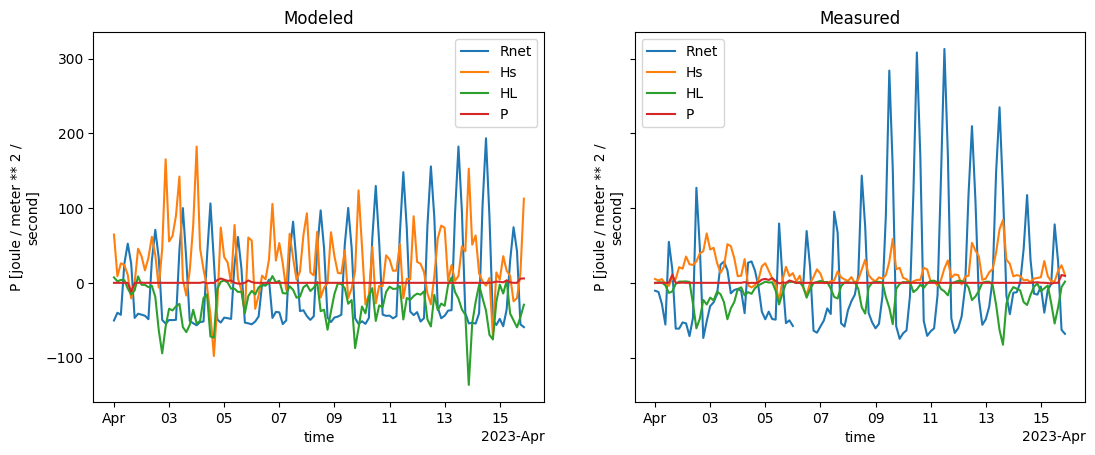

In [13]:
fig, axes = plt.subplots(1,2, figsize=((12.8, 4.8)), sharex=True, sharey=True)
time_slice = slice('20230401', '20230415')
modeled['Rnet'].sel(time=time_slice).plot(label = 'Rnet', ax=axes[0])
modeled['sens_heat_flux'].sel(time=time_slice).plot(label = 'Hs', ax=axes[0])
modeled['lat_heat_flux'].sel(time=time_slice).plot(label = 'HL', ax=axes[0])
modeled['P'].sel(time=time_slice).plot(label = 'P', ax=axes[0])

measured['Rnet'].sel(time=time_slice).plot(label = 'Rnet', ax=axes[1])
measured['sens_heat_flux'].sel(time=time_slice).plot(label = 'Hs', ax=axes[1])
measured['lat_heat_flux'].sel(time=time_slice).plot(label = 'HL', ax=axes[1])
measured['P'].sel(time=time_slice).plot(label = 'P', ax=axes[1])

axes[0].set_title('Modeled'); axes[0].legend()
axes[1].set_title('Measured'); axes[1].legend()
plt.show()

Ok, so we see some interesting things here. Most obviously, modeled net radiation is smaller than measured net radiation, particularly starting on April 8th. What do we recall from previous labs about what happened around this date that the model doesn't pick up on?

Second, it appears that the latent and sensible heat fluxes are larger in the model-world than in the real world. 

## Gridded results

In [14]:
modeled_gridded = xr.open_dataset("openamundsen_results/output_grids.nc")

Let's check out melt rates at the four dates throughout May and June. The plot of modeled SWE (above) shows that modeled melt at Kettle Ponds occurs all throughout May, but higher altitude locations probably melted out later, in June.

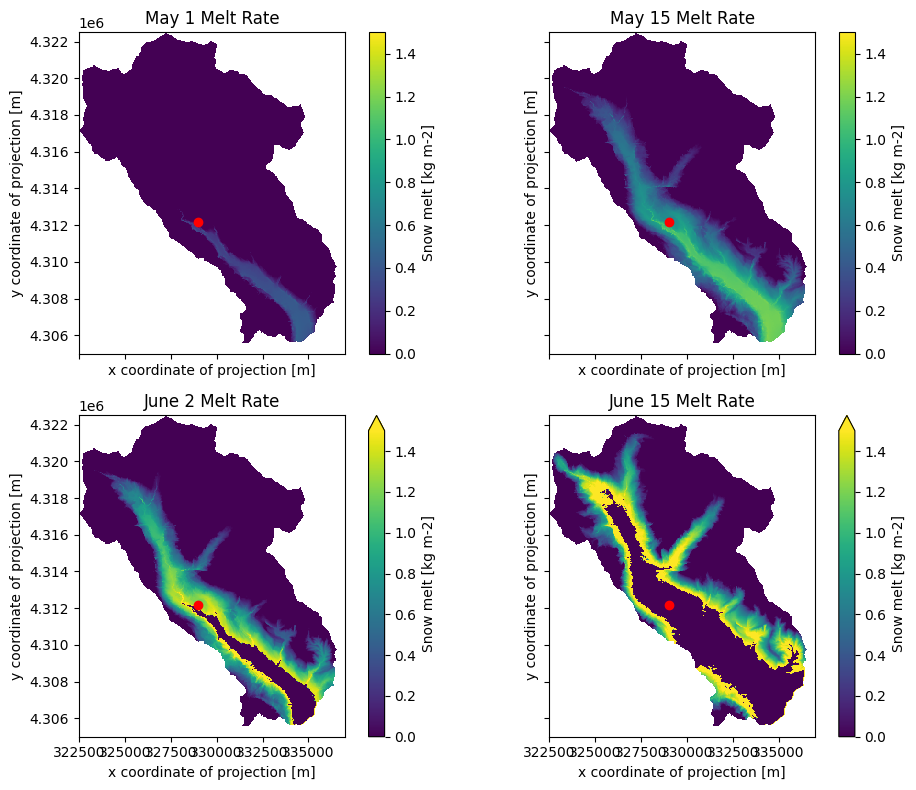

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot for May 1
modeled_gridded['melt'].sel(time='2023-05-01T00:00:00.000000000').plot(ax=axes[0], cmap='viridis', vmin=0, vmax=1.5)
axes[0].set_title('May 1 Melt Rate')
# Plot for May 15
modeled_gridded['melt'].sel(time='2023-05-15T00:00:00.000000000').plot(ax=axes[1], cmap='viridis', vmin=0, vmax=1.5)
axes[1].set_title('May 15 Melt Rate')
# Plot for June 2
modeled_gridded['melt'].sel(time='2023-06-02T00:00:00.000000000').plot(ax=axes[2], cmap='viridis', vmin=0, vmax=1.5)
axes[2].set_title('June 2 Melt Rate')
# Plot for June 15
modeled_gridded['melt'].sel(time='2023-06-14T00:00:00.000000000').plot(ax=axes[3], cmap='viridis', vmin=0, vmax=1.5)
axes[3].set_title('June 15 Melt Rate')

kps_loc = gpd.GeoSeries([Point(-106.972983, 38.941817, 0)],
    index = ['Kettle Ponds'],
    crs = 'epsg:4326'
).to_crs(modeled_gridded.rio.crs)

for ax in axes.flatten():
    # Set all the plots to have the same x and y-axis limits, and set the aspect ratio to be equal
    ax.set_xlim(322500, 337000)
    ax.set_ylim(4305000, 4322500)
    ax.set_aspect('equal')
    # plot the KPS location with a red dot
    kps_loc.plot(ax=ax, color='red')
    
plt.tight_layout()
plt.show()

Cool! So we see on May 1 that melt was beginning at the lowest elevation parts of the basin (see the DEM for the upper East River Valley below). 

We also see that by May 15, melt was creeping up in elevation, mostly occuring in the low elevation, valley center. 

By June 2, the lowest parts of the valley had melted out completely and so no more melt could occur. Surrounding the lowest elevation areas, melt was most intense.

By June 15, even more low parts of the valley had melted out, and a higher elevation band was melting out. These plots also show that for higher elevation areas in the basin, not much melt had ocurred by June 15th. Unfortunately, our Kettle Ponds measurements did not go past June 19, and we only ran the model till June 15th. To model the full snowpack at higher elevations, we would need to run the model up until a later date.

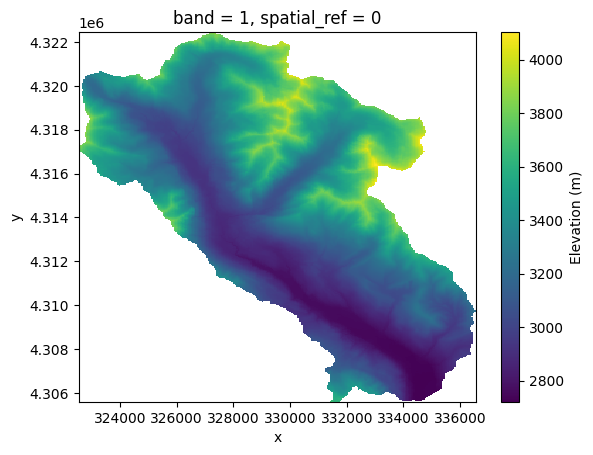

In [16]:
dem = rix.open_rasterio("../data/openamundsen/dem_uppereastriver_50.asc")
dem.plot(cbar_kwargs={'label': "Elevation (m)"})
plt.show()